# [DIS 1] ReLUs and Neural Network Intuition

In [1]:
!pip install ipympl torchviz
!pip install torch==1.13 --extra-index-url https://download.pytorch.org/whl/cpu
# restart your runtime after this step

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.3/510.3 KB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 15.5 MB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=fe1d61e6c01a9cba9536f63e254c79b510c787de2f47bba6facccdd6e2a31d0a
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.5/198.5 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.13.0+cpu which is incompatible.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.13.0+cpu which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.13.0+cpu which is incompatible.


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from torchvision.models.feature_extraction import create_feature_extractor
from ipywidgets import fixed, interactive, widgets
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# enable matplotlib widgets;

# on Google Colab
from google.colab import output
output.enable_custom_widget_manager()

%matplotlib widget

In [3]:
def to_torch(x):
    return torch.from_numpy(x).float()


def to_numpy(x):
    return x.detach().numpy()


def plot_data(X, y, X_test, y_test):
    clip_bound = 2.5
    plt.xlim(0, 1)
    plt.ylim(-clip_bound, clip_bound)
    plt.scatter(X[:, 0], y, c='darkorange', s=40.0, label='training data points')
    plt.plot(X_test, y_test, '--', color='royalblue', linewidth=2.0, label='Ground truth')


def plot_relu(bias, slope):
    plt.scatter([-bias / slope], 0, c='darkgrey', s=40.0)
    if slope > 0 and bias < 0:
        plt.plot([0, -bias / slope, 1], [0, 0, slope * (1 - bias)], ':')
    elif slope < 0 and bias > 0:
        plt.plot([0, -bias / slope, 1], [-bias * slope, 0, 0], ':')


def plot_relus(params):
    slopes = to_numpy(params[0]).ravel()
    biases = to_numpy(params[1])
    for relu in range(biases.size):
        plot_relu(biases[relu], slopes[relu])


def plot_function(X_test, net):
    y_pred = net(to_torch(X_test))
    plt.plot(X_test, to_numpy(y_pred), '-', color='forestgreen', label='prediction')


def plot_update(X, y, X_test, y_test, net, state=None):
    if state is not None:
        net.load_state_dict(state)
    plt.figure(figsize=(10, 7))
    plot_relus(list(net.parameters()))
    plot_function(X_test, net)
    plot_data(X, y, X_test, y_test)
    plt.legend()
    plt.show();


def train_network(X, y, X_test, y_test, net, optim, n_steps, save_every, initial_weights=None, verbose=False):
    loss = torch.nn.MSELoss()
    y_torch = to_torch(y.reshape(-1, 1))
    X_torch = to_torch(X)
    if initial_weights is not None:
        net.load_state_dict(initial_weights)
    history = {}
    for s in range(n_steps):
        subsample = np.random.choice(y.size, y.size // 5)
        step_loss = loss(y_torch[subsample], net(X_torch[subsample, :]))
        optim.zero_grad()
        step_loss.backward()
        optim.step()
        if (s + 1) % save_every == 0 or s == 0:
#             plot_update(X, y, X_test, y_test, net)
            history[s + 1] = {}
            history[s + 1]['state'] = copy.deepcopy(net.state_dict())
            with torch.no_grad():
                test_loss = loss(to_torch(y_test.reshape(-1, 1)), net(to_torch(X_test)))
            history[s + 1]['train_error'] = to_numpy(step_loss).item()
            history[s + 1]['test_error'] = to_numpy(test_loss).item()
            if verbose:
                print("SGD Iteration %d" % (s + 1))
                print("\tTrain Loss: %.3f" % to_numpy(step_loss).item())
                print("\tTest Loss: %.3f" % to_numpy(test_loss).item())
            else:
                # Print update every 10th save point
                if (s + 1) % (save_every * 10) == 0:
                    print("SGD Iteration %d" % (s + 1))

    return history


def plot_test_train_errors(history):
    sample_points = np.array(list(history.keys()))
    etrain = [history[s]['train_error'] for s in history]
    etest = [history[s]['test_error'] for s in history]
    plt.plot(sample_points / 1e3, etrain, label='Train Error')
    plt.plot(sample_points / 1e3, etest, label='Test Error')
    plt.xlabel("Iterations (1000's)")
    plt.ylabel("MSE")
    plt.yscale('log')
    plt.legend()
    plt.show();


def make_iter_slider(iters):
    # print(iters)
    return widgets.SelectionSlider(
        options=iters,
        value=1,
        description='SGD Iterations: ',
        disabled=False
    )


def history_interactive(history, idx, X, y, X_test, y_test, net):
    plot_update(X, y, X_test, y_test, net, state=history[idx]['state'])
    plt.show()
    print("Train Error: %.3f" % history[idx]['train_error'])
    print("Test Error: %.3f" % history[idx]['test_error'])


def make_history_interactive(history, X, y, X_test, y_test, net):
    sample_points = list(history.keys())
    return interactive(history_interactive,
                       history=fixed(history),
                       idx=make_iter_slider(sample_points),
                       X=fixed(X),
                       y=fixed(y),
                       X_test=fixed(X_test),
                       y_test=fixed(y_test),
                       net=fixed(net))


%matplotlib inline

# Generate Training and Test Data

We are using piecewise linear function. Our training data has added noise $y = f(x) + \epsilon,\, \epsilon \sim \mathcal{N}(0, \sigma^2)$. The test data is noise free.

_Once you have gone through the discussion once you may wish to adjust the number of training samples and noise variance to see how gradient descent behaves under the new conditions._

In [4]:
f_type = 'piecewise_linear'

def f_true(X, f_type):
    if f_type == 'sin(20x)':
        return np.sin(20 * X[:,0])
    else:
        TenX = 10 * X[:,0]
        _ = 12345
        return (TenX - np.floor(TenX)) * np.sin(_ * np.ceil(TenX)) - (TenX - np.ceil(TenX)) * np.sin(_ * np.floor(TenX)) 
    
n_features = 1
n_samples = 200
sigma = 0.1
rng = np.random.RandomState(1)

# Generate train data
X = np.sort(rng.rand(n_samples, n_features), axis=0)
y = f_true(X, f_type) + rng.randn(n_samples) * sigma

# Generate NOISELESS test data
X_test = np.concatenate([X.copy(), np.expand_dims(np.linspace(0., 1., 1000), axis=1)])
X_test = np.sort(X_test, axis=0)
y_test = f_true(X_test, f_type)

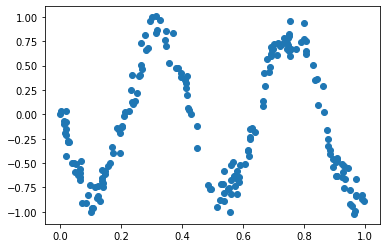

In [5]:
plt.scatter(X, y)
plt.show()

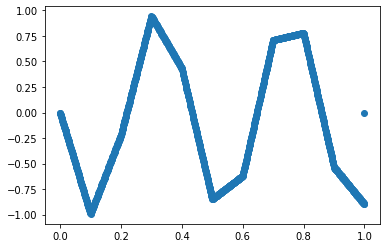

In [6]:
plt.scatter(X_test, y_test)
plt.show()

# Define the Neural Networks

We will learn the piecewise linear target function using a simple 1-hidden layer neural network with ReLU non-linearity, defined by
$$ \hat{y} = \mathbf{W}^{(2)} \Phi \left( \mathbf{W}^{(1)} x + \mathbf{b}^{(1)} \right) + \mathbf{b}^{(2)} $$
where $\Phi(x) = ReLU(x)$ and superscripts refer to indices, not the power operator.

We will also create two SGD optimizers to allow us to choose whether to train all parameters or only the linear output layer's parameters. Note that we use separate learning rates for the two version of training. There is too much variance in the gradients when training all layers to use a large learning rate, so we have to decrease it.

We will modify the default initialization of the biases so that the ReLU elbows are all inside the region we are interested in.

We create several versions of this network with varying widths to explore how hidden layer width impacts learning performance.

_Once you have gone through the discussion once you may wish to train networks with even larger widths to see how they behave under the three different training paradigms in this notebook._

In [7]:
# Don't rerun this cell after training or you will lose all your work
nets_by_size = {}

In [8]:
widths = [10, 20, 40]
for width in widths:
    # Define a 1-hidden layer ReLU nonlinearity network
    net = nn.Sequential(nn.Linear(1, width),
                        nn.ReLU(),
                        nn.Linear(width, 1))
    loss = nn.MSELoss()
    # Get trainable parameters
    weights_all = list(net.parameters())
    # Get the output weights alone
    weights_out = weights_all[2:]
    # Adjust initial biases so elbows are in [0,1]
    elbows = np.sort(np.random.rand(width))
    new_biases = -elbows * to_numpy(weights_all[0]).ravel()
    weights_all[1].data = to_torch(new_biases)
    # Create SGD optimizers for outputs alone and for all weights
    lr_out = 0.2
    lr_all = 0.02
    opt_all = torch.optim.SGD(params=weights_all, lr=lr_all)
    opt_out = torch.optim.SGD(params=weights_out, lr=lr_out)
    # Save initial state for comparisons
    initial_weights = copy.deepcopy(net.state_dict())
    # print("Initial Weights", initial_weights)
    nets_by_size[width] = {'net': net, 'opt_all': opt_all, 
                           'opt_out': opt_out, 'init': initial_weights}

# Train the neural networks

----------------------------------------
Width 10
SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 10


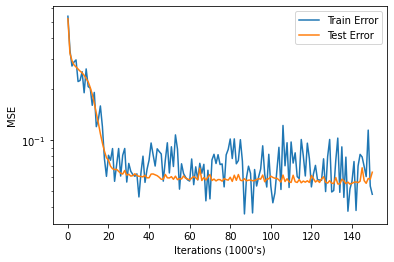

----------------------------------------
Width 20
SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 20


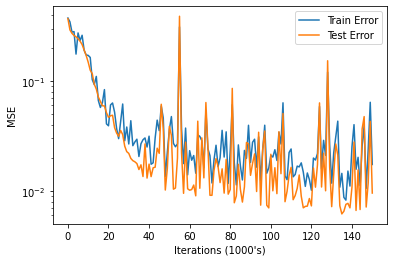

----------------------------------------
Width 40
SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 40


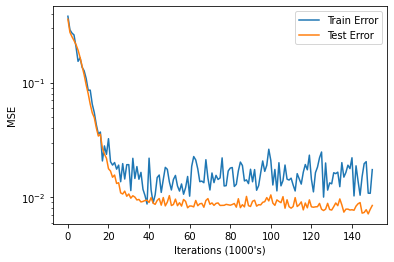

----------------------------------------
Trained all layers in 3.1 minutes


In [9]:
n_steps = 150000
save_every = 1000
t0 = time.time()
for w in widths:
    print("-"*40)
    print("Width", w)
    new_net = nn.Sequential(nn.Linear(1, w),
                        nn.ReLU(),
                        nn.Linear(w, 1))
    new_net.load_state_dict(nets_by_size[w]['net'].state_dict().copy())
    opt_all = torch.optim.SGD(params=new_net.parameters(), lr=lr_all)
    initial_weights = nets_by_size[w]['init']
    history_all = train_network(X, y, X_test, y_test, 
                            new_net, optim=opt_all, 
                            n_steps=n_steps, save_every=save_every, 
                            initial_weights=initial_weights,
                            verbose=False)
    nets_by_size[w]['trained_net'] = new_net
    nets_by_size[w]['hist_all'] = history_all
    print("Width", w)
    plot_test_train_errors(history_all)
t1 = time.time()
print("-"*40)
print("Trained all layers in %.1f minutes" % ((t1 - t0) / 60))

# (a) Visualize Gradients

Visualize the features corresponding to
$\frac{\partial}{\partial w_i^{(1)}} y(x)$
and
$\frac{\partial}{\partial b_i^{(1)}} y(x)$
where
$w^{(1)}_i$
are
the first hidden layer's weights and the
$b^{(1)}_i$
are the first hidden layer's biases. These derivatives should be evaluated at
at least both the random initialization and the final trained
network. When visualizing these features, plot them as a function
of the scalar input $x$, the same way that the notebook plots the
constituent "elbow" features that are the outputs of the
penultimate layer.

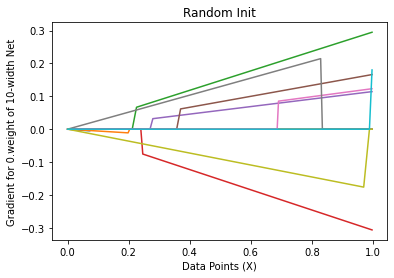

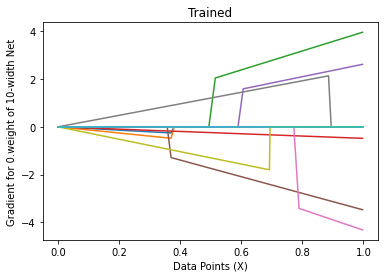

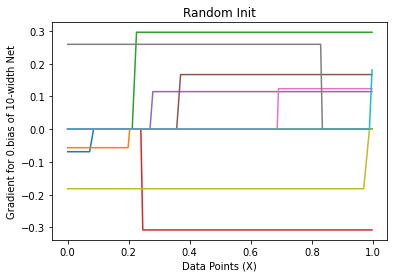

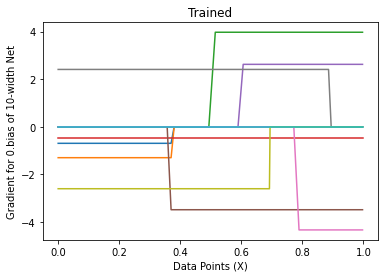

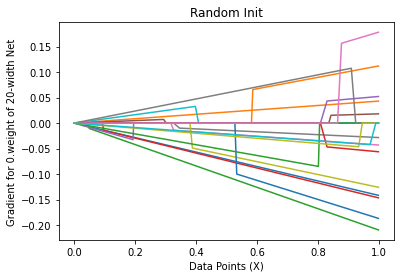

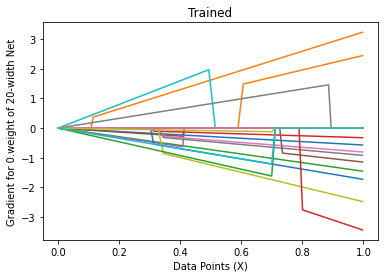

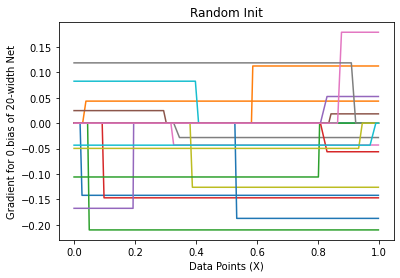

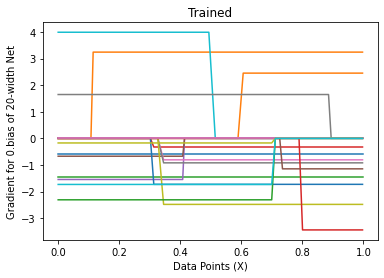

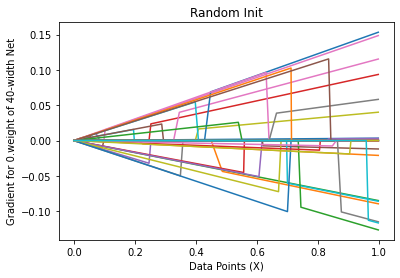

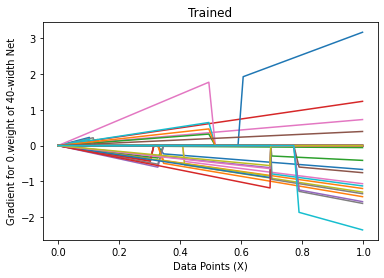

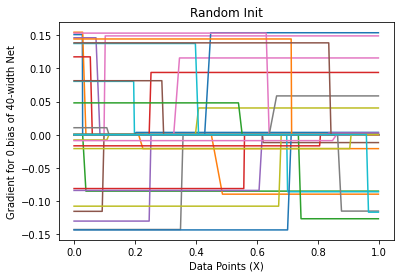

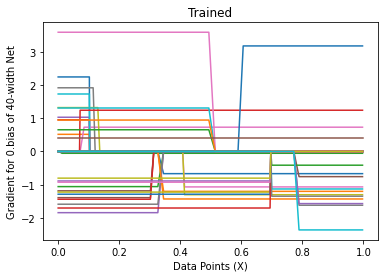

In [10]:
def backward_and_plot_grad(X, model, vis_name='all', title='', legend=False):
    """
    Run backpropagation on `model` using `X` as the input
    to compute the gradient w.r.t. parameters of `y`,
    and then visualize collected gradients according to `vis_name`
    """
    width = model[0].out_features  # the width is the number of hidden units.
    gradients = np.zeros((width, X.shape[0]))
    num_pts = 0
    gradient_collect, vis_collect = { }, { }
    for x in X:
        y = model(to_torch(x))

        ########################################################################
        # TODO: Complete the following part to run backpropagation. (2 lines)
        # Hint: Remember to set grad to zero before backpropagation
        ########################################################################
        model.zero_grad()
        y.backward()
        ########################################################################
        
        # collect gradients from `p.grad.data`
        for n, p in model.named_parameters():
            for w_idx, w_grad in enumerate( p.grad.data.reshape(-1) ):
                if f'{n}.{w_idx}' not in gradient_collect:
                    gradient_collect[ f'{n}.{w_idx}' ] = {'x':[], 'y': []}
                if vis_name == 'all' or vis_name == n:
                    if f'{n}.{w_idx}' not in vis_collect:
                        vis_collect[f'{n}.{w_idx}'] = True
                gradient_collect[ f'{n}.{w_idx}' ]['y'].append( w_grad.item() )
                gradient_collect[ f'{n}.{w_idx}' ]['x'].append( x )
    
    for w_n in vis_collect:
        # we assume that X is sorted, so we use line plot
        plt.plot( X, gradient_collect[w_n]['y'], label=w_n )
        
    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Gradient for {vis_name} of {width}-width Net')
    if legend:
        plt.legend()
    plt.title(title)
    plt.show()


for width in nets_by_size:
    backward_and_plot_grad(X, nets_by_size[width]['net'], '0.weight', 'Random Init')
    backward_and_plot_grad(X, nets_by_size[width]['trained_net'], '0.weight', 'Trained')
    backward_and_plot_grad(X, nets_by_size[width]['net'], '0.bias', 'Random Init')
    backward_and_plot_grad(X, nets_by_size[width]['trained_net'], '0.bias', 'Trained')

# (b) SVD for feature matrix

During training, we can imagine that we have a generalized
linear model with a feature matrix corresponding to the linearized
features corresponding to each learnable parameter. We know from
our analysis of gradient descent, that the singular values and
singular vectors corresponding to this feature matrix are
important.

Use the SVD of this feature matrix to plot both the singular values and visualize the “principle
features” that correspond to the d-dimensional singular vectors multiplied by all the features
corresponding to the parameters

(HINT: Remember that the feature matrix whose SVD you are
taking has $n$ rows where each row corresponds to one training
point and $d$ columns where each column corresponds to each of
the learnable features. Meanwhile, you are going to be
plotting/visualizing the "principle features" as functions of
$x$ even at places where you don't have training points.)

Width 10


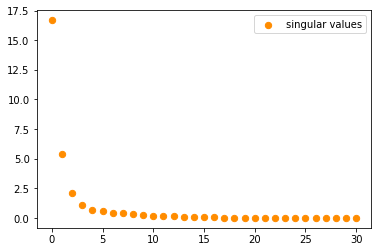

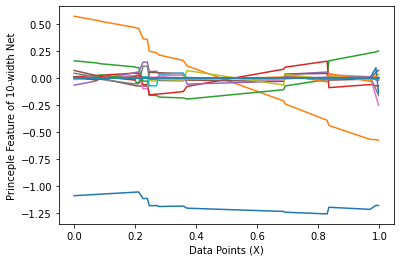

Width 20


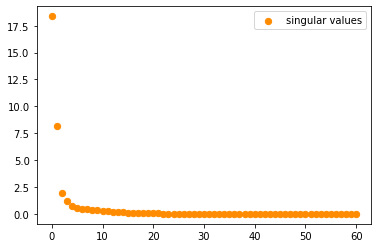

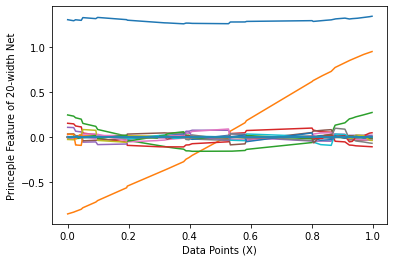

Width 40


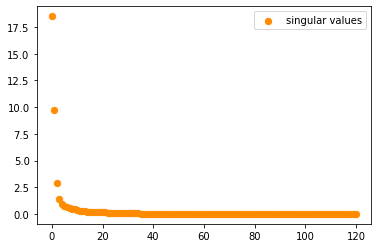

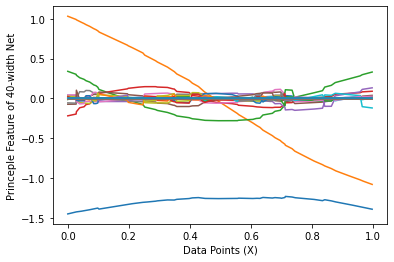

In [11]:
def compute_svd_plot_features(X, y, X_test, y_test, model):
    width = model[0].out_features  # the width is the number of hidden units.
    gradients = np.zeros((width, X.shape[0]))
    num_pts = 0
    gradient_collect, vis_collect = { }, { }
    for x in X:
        y = model(to_torch(x))

        ########################################################################
        # TODO: Complete the following part to run backpropagation. (2 lines)
        # Hint: The same as part (a)
        ########################################################################
        model.zero_grad()
        y.backward()
        ########################################################################

        for n, p in model.named_parameters():
            for w_idx, w_grad in enumerate( p.grad.view(-1).data ):
                if f'{n}.{w_idx}' not in gradient_collect:
                    gradient_collect[ f'{n}.{w_idx}' ] = {'x':[], 'y': []}
                gradient_collect[ f'{n}.{w_idx}' ]['y'].append( w_grad.item() )
                gradient_collect[ f'{n}.{w_idx}' ]['x'].append( x )

    feature_matrix = []
    for w_n in gradient_collect:
        feature_matrix.append( gradient_collect[w_n]['y'] )
    feature_matrix = np.array( feature_matrix ).T

    ############################################################################
    # TODO: Complete the following part to SVD-decompose the feature matrix.
    #       (1 line)
    # Hint: the shape of u, s, vh should be [n, d], [d], and [d, d]
    #       respectively
    ############################################################################
    u, s, vh = np.linalg.svd(feature_matrix, full_matrices=False)
    ############################################################################

    plt.scatter(np.arange(s.shape[0]), s, c='darkorange', s=40.0, label='singular values')
    plt.legend()
    plt.show()

    # Construct more training matrix
    ############################################################################
    # TODO: Complete the following part to compute the pricipal feature
    #       (1 line)
    ############################################################################
    princple_feature = feature_matrix @ vh.T
    ############################################################################


    for w_idx in range(feature_matrix.shape[1]):
        plt.plot( X, princple_feature.T[w_idx] )
        
    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Princeple Feature of {width}-width Net')
    plt.show()

for w in widths:
    net = nets_by_size[w]['net']
    print("Width", w)
    compute_svd_plot_features(X, y, X_test, y_test, net)


# (c) Two-layer Network

Augment the jupyter notebook to add a second hidden
layer of the same size as the first hidden layer, fully connected
to the first hidden layer.

Allow the visualization of the features corresponding
to the parameters in both hidden layers, as well as the
"principle features" and the singular values.

SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 40


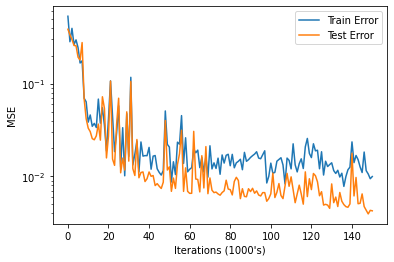

SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 40


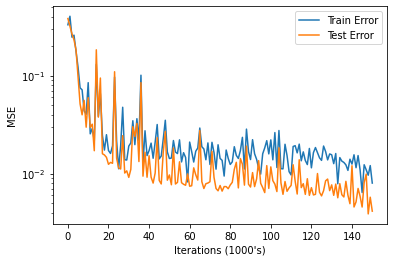

SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 40


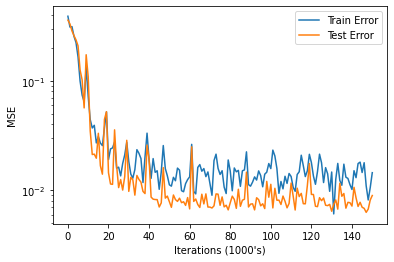

In [12]:
############################################################################
# TODO: Write your code here
############################################################################

widths = [10, 20, 40]

two_layer_nets_by_size = {}

for width in widths:
    net = nn.Sequential(nn.Linear(1, width),
                        nn.ReLU(),
                        nn.Linear(width, width),
                        nn.ReLU(),
                        nn.Linear(width, 1))
    new_net = nn.Sequential(nn.Linear(1, width),
                        nn.ReLU(),
                        nn.Linear(width, width),
                        nn.ReLU(),
                        nn.Linear(width, 1))
    new_net.load_state_dict(net.state_dict().copy())
    lr_all = 0.02
    opt_all = torch.optim.SGD(params=new_net.parameters(), lr=lr_all)
    loss = nn.MSELoss()
    history_all = train_network(X, y, X_test, y_test, 
                            new_net, optim=opt_all, 
                            n_steps=n_steps, save_every=save_every, 
                            initial_weights=None,
                            verbose=False)
    print("Width", w)
    plot_test_train_errors(history_all)
    two_layer_nets_by_size[width] = {
        'net': net,
        'opt_all': opt_all,
        'trained_net': new_net,
        'hist_all': history_all
    }

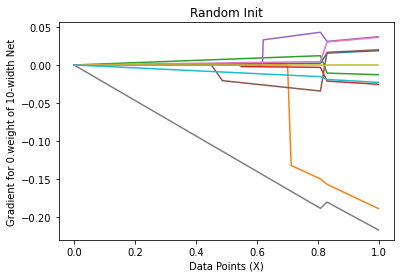

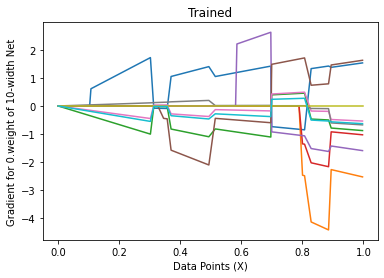

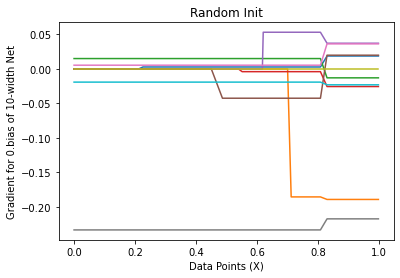

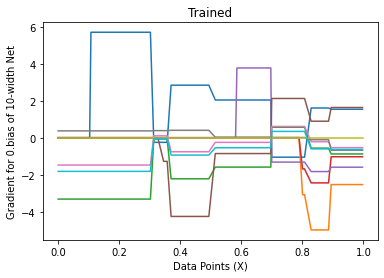

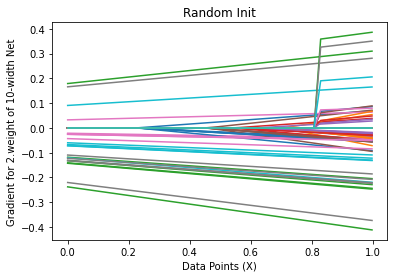

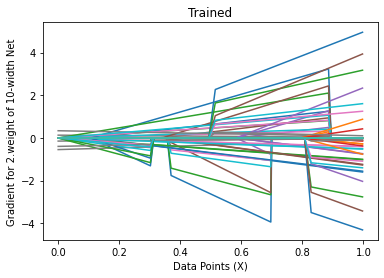

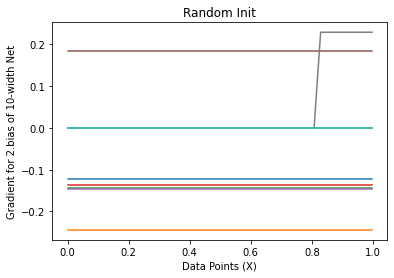

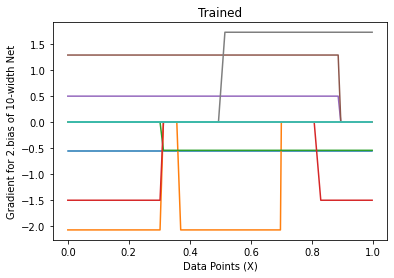

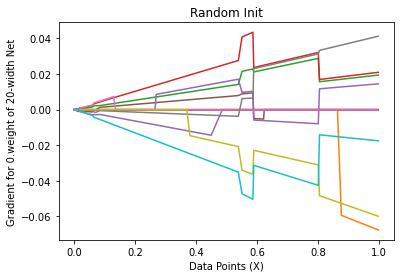

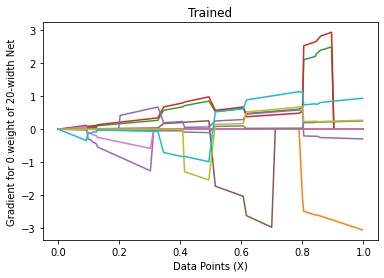

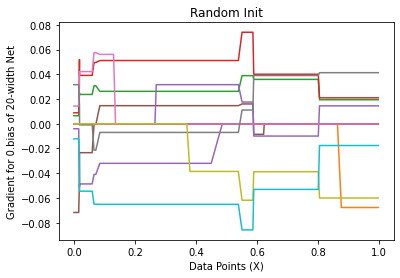

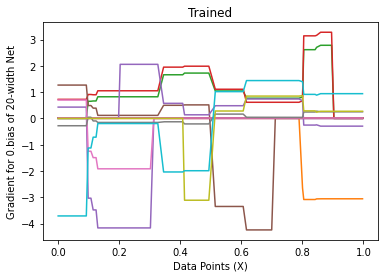

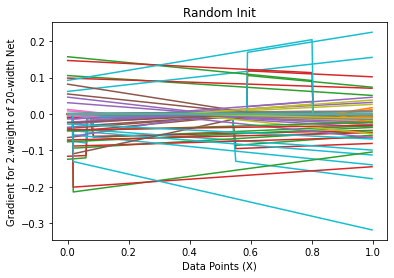

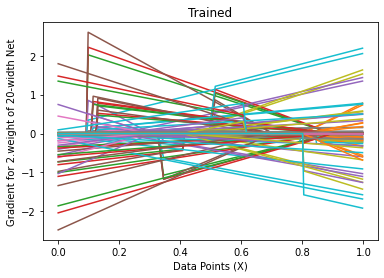

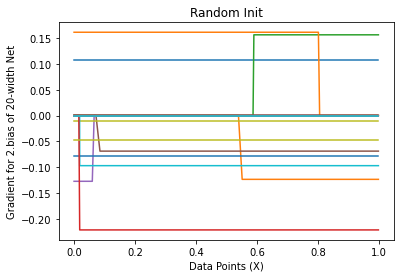

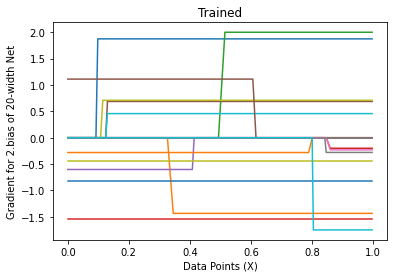

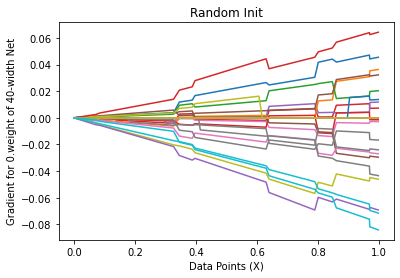

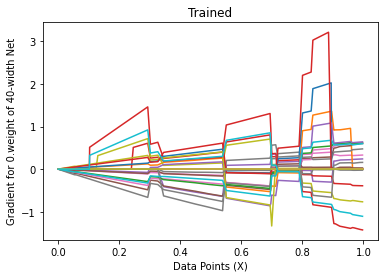

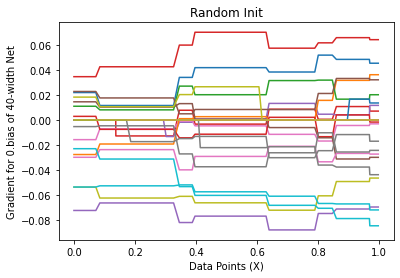

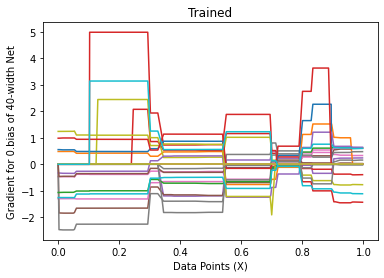

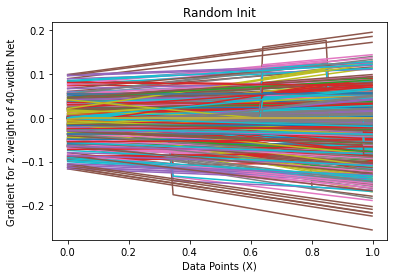

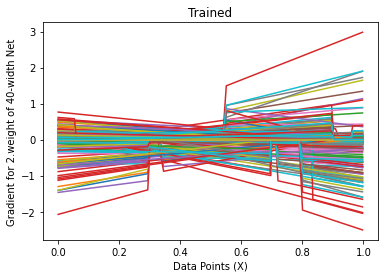

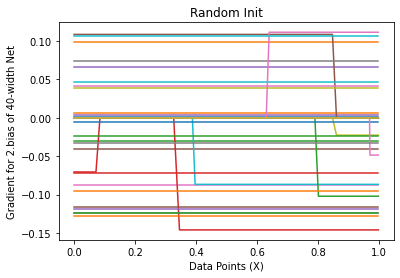

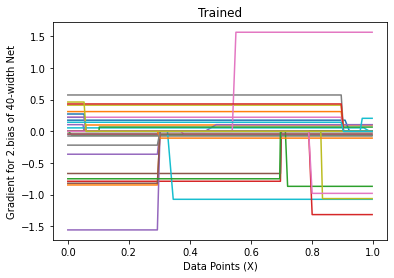

In [13]:
def backward_and_plot_grad(X, model, vis_name='all', title='', legend=False):
    """
    Run backpropagation on `model` using `X` as the input
    to compute the gradient w.r.t. parameters of `y`,
    and then visualize collected gradients according to `vis_name`
    """
    width = model[0].out_features  # the width is the number of hidden units.
    gradients = np.zeros((width, X.shape[0]))
    num_pts = 0
    gradient_collect, vis_collect = { }, { }
    for x in X:
        y = model(to_torch(x))

        model.zero_grad()
        y.backward()
        
        # collect gradients from `p.grad.data`
        for n, p in model.named_parameters():
            for w_idx, w_grad in enumerate( p.grad.data.reshape(-1) ):
                if f'{n}.{w_idx}' not in gradient_collect:
                    gradient_collect[ f'{n}.{w_idx}' ] = {'x':[], 'y': []}
                if vis_name == 'all' or vis_name == n:
                    if f'{n}.{w_idx}' not in vis_collect:
                        vis_collect[f'{n}.{w_idx}'] = True
                gradient_collect[ f'{n}.{w_idx}' ]['y'].append( w_grad.item() )
                gradient_collect[ f'{n}.{w_idx}' ]['x'].append( x )
    
    for w_n in vis_collect:
        # we assume that X is sorted, so we use line plot
        plt.plot( X, gradient_collect[w_n]['y'], label=w_n )
        
    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Gradient for {vis_name} of {width}-width Net')
    if legend:
        plt.legend()
    plt.title(title)
    plt.show()


for width in two_layer_nets_by_size:
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['net'], '0.weight', 'Random Init')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['trained_net'], '0.weight', 'Trained')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['net'], '0.bias', 'Random Init')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['trained_net'], '0.bias', 'Trained')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['net'], '2.weight', 'Random Init')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['trained_net'], '2.weight', 'Trained')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['net'], '2.bias', 'Random Init')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['trained_net'], '2.bias', 'Trained')

Width 10
(200, 141)


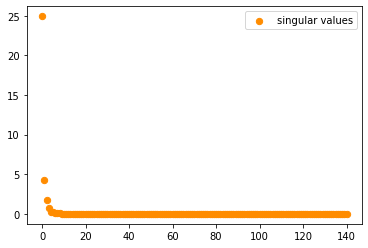

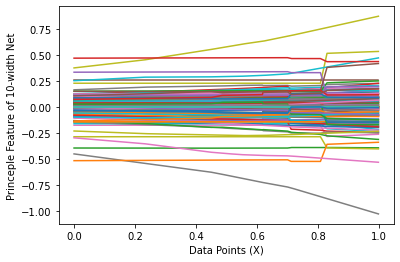

Width 20
(200, 481)


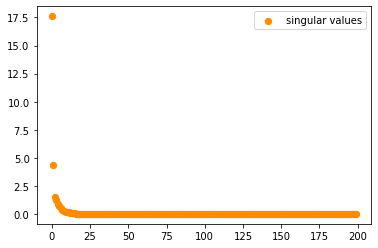

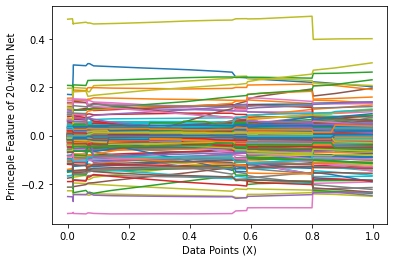

Width 40
(200, 1761)


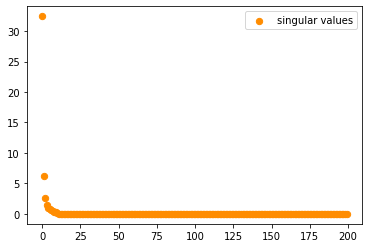

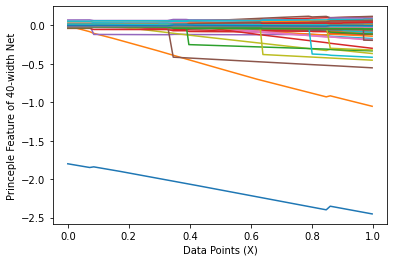

In [15]:
def compute_svd_plot_features(X, y, X_test, y_test, model):
    width = model[0].out_features  # the width is the number of hidden units.
    gradients = np.zeros((width, X.shape[0]))
    num_pts = 0
    feature_matrix = []
    for x in X:
        y = model(to_torch(x))

        model.zero_grad()
        y.backward()

        feature_vector = []
        for n, p in model.named_parameters():
            for w_idx, w_grad in enumerate( p.grad.view(-1).data ):
                feature_vector.append(w_grad.cpu().numpy().reshape(-1))
        feature_vector = np.concatenate(feature_vector)
        feature_matrix.append(feature_vector)

    feature_matrix = np.stack( feature_matrix )
    print(feature_matrix.shape)

    u, s, vh = np.linalg.svd(feature_matrix, full_matrices=True)
    # need full_matrices = True here because the NN could be overparameterized
    # when it has two layers

    plt.scatter(np.arange(s.shape[0]), s, c='darkorange', s=40.0, label='singular values')
    plt.legend()
    plt.show()

    princple_feature = feature_matrix @ vh

    for w_idx in range(feature_matrix.shape[1]):
        plt.plot( X, princple_feature.T[w_idx] )
        
    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Princeple Feature of {width}-width Net')
    plt.show()

for w in widths:
    net = two_layer_nets_by_size[w]['net']
    print("Width", w)
    compute_svd_plot_features(X, y, X_test, y_test, net)
